# Vehicle Detection and Tracking
________________________________________________
### Goals for the project:
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images
* Apply a color transform and append binned color features, as well as histograms of color, to HOG feature vector
* Normalize features and randomize a selection for training and testing
* Train a classifier (Linear SVM)
* Implement a sliding-window technique and use trained classifier to search for vehicles in images
* Create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles 
* Estimate a bounding box for vehicles detected
* Draw boxes around detected vehicles
________________________________________________

### First I'll perform a Histogram of Oriented Gradients (HOG) feature extraction on some test images

In [1]:
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.image as mpimg
import glob
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Here is a helper function for visualizing and saving output
def plot_imgs(imgs, titles, figsize=(24, 9), cmap='gray', save=False):
    # Number of images
    num_imgs = len(imgs)
    
    # Create figure
    f, axes = plt.subplots(1, num_imgs, figsize=figsize)
    f.tight_layout()
    for i in range(num_imgs):
        axes[i].imshow(imgs[i], cmap=cmap)
        axes[i].set_title(titles[i], fontsize=50)
    
    # Save figure
    if save == True:
        plt.savefig('./output_images/' + titles[-1] + '.png', bbox_inches='tight')
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
# Get HOG features from an image
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if visualizing output
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

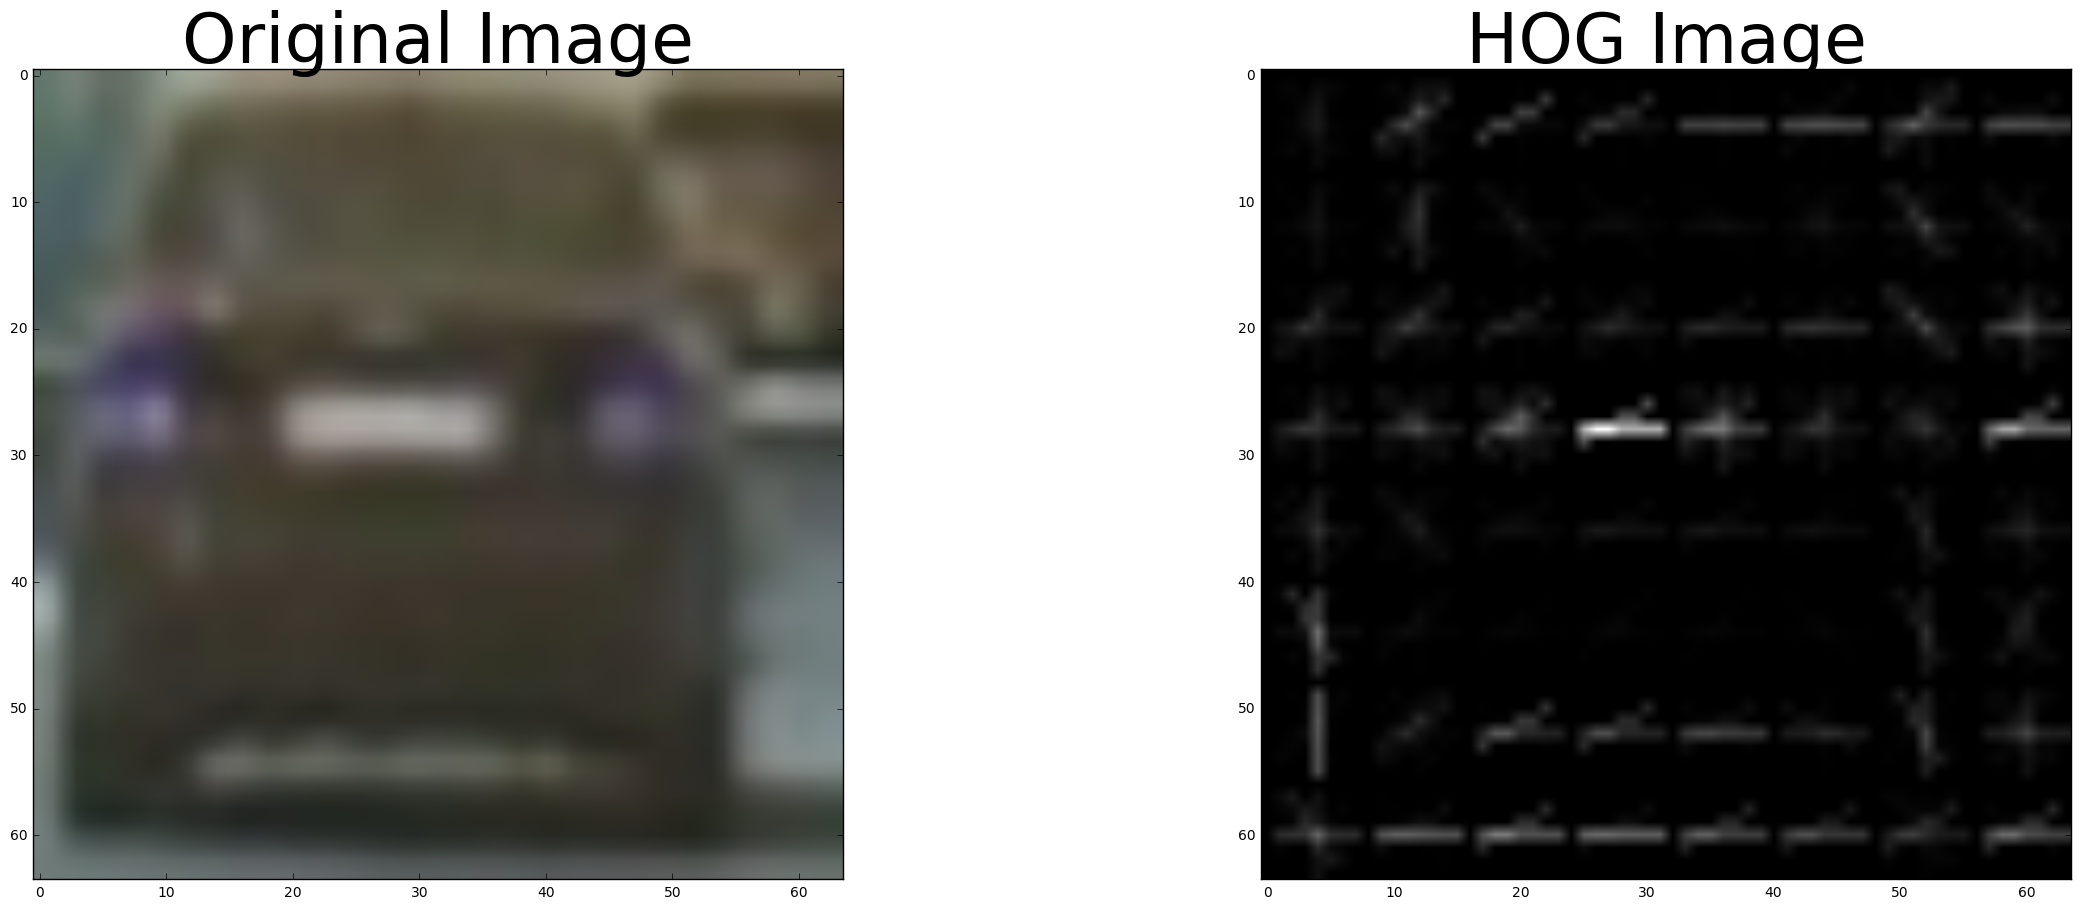

In [3]:
# Now I'll visualise an HOG image
# First I'll create variables for the arguments
image = cv2.imread('./vehicles/GTI_MiddleClose/image0000.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ORIENT = 8
PIX_PER_CELL = 8
CELL_PER_BLOCK = 2

features, hog_image = get_hog_features(gray, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, vis=True)
plot_imgs((image, hog_image), ('Original Image', 'HOG Image', 'HOG'), save=True)

### Now I'll apply a color transform and append binned color features, as well as histograms of color, to HOG feature vector

In [4]:
# Convert to specified colorspace
def convert_color(img, conv='BGR2YUV'):
    if conv == 'BGR2YUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    elif conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    elif conv == 'BGR2HLS':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    elif conv == 'BGR2LUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    elif conv == 'BGR2HSV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Bin color features    
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Histogram of colors
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [7]:
# Extract features from a list of images
def get_color_features(imgs, conv='BGR2YUV', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img in imgs:
        # Read in each one by one
        img = cv2.imread(img)
        # apply color conversion
        img = convert_color(img, conv='BGR2YUV')
        # Apply bin_spatial() to get spatial color features
        color_features = bin_spatial(img, size=spatial_size)
        # Apply color_hist() to get color histogram features
        hist_features = color_hist(img, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((color_features, hist_features)))
    # Return list of feature vectors
    return features

### Next, I will combine and normalize color features

In [8]:
cars = glob.glob('./vehicles/*/*.png')
notcars = glob.glob('./non-vehicles/*/*.png')
        
car_features = get_color_features(cars, conv='BGR2YUV', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features = get_color_features(notcars, conv='BGR2YUV', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))

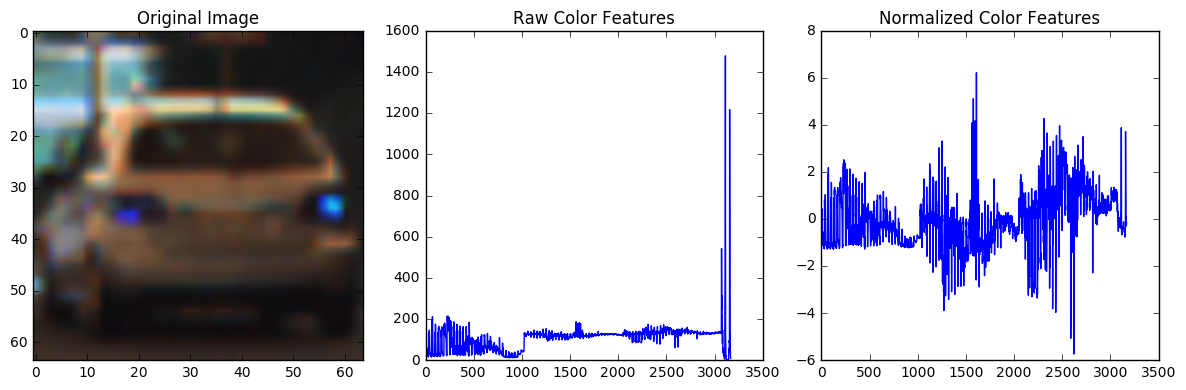

In [9]:
if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(cv2.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Color Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Color Features')
    fig.tight_layout()
    plt.savefig('./output_images/normalized_color.png', bbox_inches='tight')
else: 
    print('Your function only returns empty feature vectors...')

### Now I will combine HOG features with color features

In [10]:
def extract_features(imgs, conv='BGR2YUV', orient=ORIENT, hog_channel=0,
                        pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK,
                        spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        img = cv2.imread(file)
        # apply color conversion
        img = convert_color(img, conv='BGR2YUV')      
        # Apply bin_spatial() to get spatial color features
        color_features = bin_spatial(img, size=spatial_size)
        # Apply color_hist() to get color histogram features
        hist_features = color_hist(img, nbins=hist_bins, bins_range=hist_range)
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(img[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(img[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(np.concatenate((color_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

In [11]:
car_features = extract_features(cars, conv='BGR2YUV', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features(notcars, conv='BGR2YUV', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))

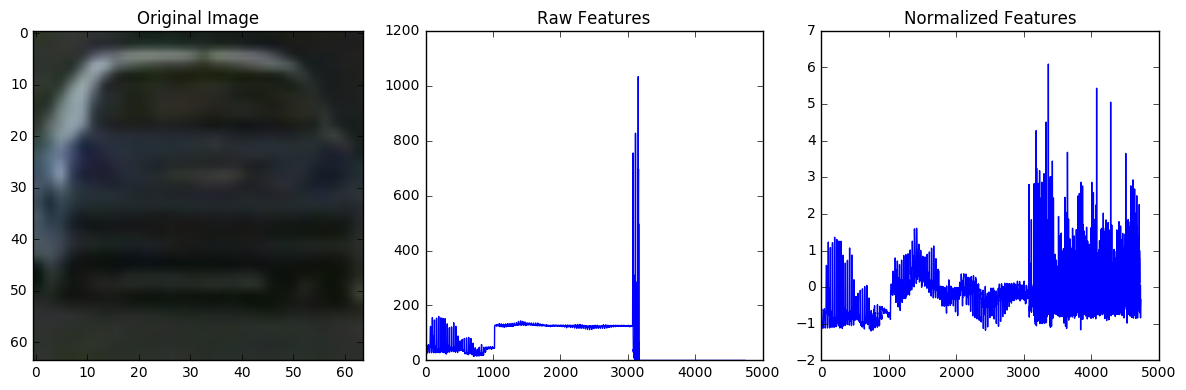

In [12]:
if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(cv2.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
    plt.savefig('./output_images/normalized_color_and_hog.png', bbox_inches='tight')
else: 
    print('Your function only returns empty feature vectors...')

### Now I'll train a classifier on the normalized features

In [13]:
from sklearn.svm import LinearSVC
import time
from sklearn.model_selection import train_test_split

# First I need labels for the dataset
# I'll make labels for cars = 1 and notcars = 0
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
svc.predict(X_test)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict')

12.48 Seconds to train SVC...
Test Accuracy of SVC =  0.9876
0.01853 Seconds to predict


### Next I need to implement a sliding window search function to find cars in an image of the road

In [14]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='BGR2YUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (32,32))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            print(spatial_features.shape, hist_features.shape, hog_features.shape)
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

In [15]:
img = cv2.imread('./test_images/test1.jpg')
ystart = 400
ystop = 656
scale = 1.5
out_img = find_cars(img, ystart, ystop, scale, svc, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, spatial_size=(32, 32), hist_bins=32)

plot_imgs(out_img, 'find_cars', save=True)

(3072,) (96,) (4704,)


ValueError: operands could not be broadcast together with shapes (1,7872) (4736,) (1,7872) 